In [1]:

from typing import Dict, Tuple
from tqdm import tqdm
import numpy as np
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F


def ddpm_schedules(beta1: float, beta2: float, T: int) -> Dict[str, torch.Tensor]:
    """
    Returns pre-computed schedules for DDPM sampling, training process.
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }


blk = lambda ic, oc: nn.Sequential(
    nn.Conv2d(ic, oc, 7, padding=3),
    nn.BatchNorm2d(oc),
    nn.LeakyReLU(),
)


def residual_resample(weights):
    """residual_resample samples from discrete distribution with probabilities `weights'
    trying to maintain diversity.

    Args:
        weights: simplex variable weights of shape [B]

    Returns:
        idcs of samples
    """
    B = len(weights)
    weights *= B/sum(weights)

    weights_floor = np.floor(weights)
    weights_remainder = weights - weights_floor
    idcs_no_replace = sum([[i]*int(w) for i, w in enumerate(weights_floor)], [])

    N_replace = sum(weights_remainder)
    N_replace = int(np.round(N_replace))
    idcs_replace = np.random.choice(B, size=N_replace, p=weights_remainder/sum(weights_remainder))
    idcs = idcs_no_replace + list(idcs_replace)
    return idcs, N_replace


class DummyEpsModel(nn.Module):
    """
    This should be unet-like, but let's don't think about the model too much :P
    Basically, any universal R^n -> R^n model should work.
    """

    def __init__(self, n_channel: int) -> None:
        super(DummyEpsModel, self).__init__()
        self.conv = nn.Sequential(  # with batchnorm
            blk(n_channel, 64),
            blk(64, 128),
            blk(128, 256),
            blk(256, 512),
            blk(512, 256),
            blk(256, 128),
            blk(128, 64),
            nn.Conv2d(64, n_channel, 3, padding=1),
        )

    def forward(self, x, t) -> torch.Tensor:
        # Lets think about using t later. In the paper, they used Tr-like positional embeddings.
        return self.conv(x)


class DDPM(nn.Module):
    def __init__(
        self,
        eps_model: nn.Module,
        betas: Tuple[float, float],
        n_T: int,
        criterion: nn.Module = nn.MSELoss(),
    ) -> None:
        super(DDPM, self).__init__()
        self.eps_model = eps_model

        # register_buffer allows us to freely access these tensors by name. It helps device placement.
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.criterion = criterion

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Makes forward diffusion x_t, and tries to guess epsilon value from x_t using eps_model.
        This implements Algorithm 1 in the paper.
        """

        _ts = torch.randint(1, self.n_T, (x.shape[0],)).to(
            x.device
        )  # t ~ Uniform(0, n_T)
        eps = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * eps
        )  # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.

        return self.criterion(eps, self.eps_model(x_t, _ts / self.n_T))
    
    def forward_trajectory(self, x: torch.Tensor, device):
        traj = [x]
        for i in range(0, self.n_T):
            b_t = 1 - self.alpha_t[i].to(device)
            z = torch.randn(*x.shape).to(device)
            x_t = torch.sqrt(1 - b_t) * traj[-1] + torch.sqrt(b_t) * z
            traj.append(x_t)
        return traj

    def sample(self, n_sample: int, size, device) -> torch.Tensor:

        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1)

        # This samples accordingly to Algorithm 2. It is exactly the same logic.
        for i in range(self.n_T, 0, -1):
            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0
            eps = self.eps_model(x_i, i / self.n_T)
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )

        return x_i

    def replacement_sample(self, n_sample: int, size, device, motif_forward, motif_mask):

        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1)

        # This samples accordingly to Algorithm 2. It is exactly the same logic.
        for i in range(self.n_T, 0, -1):
            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0
            motif_i = motif_forward[i]
            x_i = x_i * (1 - motif_mask) + motif_i
            eps = self.eps_model(x_i, i / self.n_T)
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )

        return x_i
    
    def reverse_distribution(self, x_t, e_t, t):
        a_t = self.alpha_t[t]
        b_t = 1 - a_t
        cum_a_t = self.alphabar_t[t]
        pred_noise = (1 - a_t) / torch.sqrt(1 - cum_a_t) * e_t
        mu_t_1 = 1 / torch.sqrt(a_t) * (x_t - pred_noise)
        sd_t_1 = torch.sqrt(b_t)
        return mu_t_1, sd_t_1
    
    def log_impt_weights(self, x_t, e_t, t, motif_forward_diffusion, motif_mask):
        """computes log importance weights
        """
        if t ==0: return torch.zeros(x_t.shape[0])
        mu, sd = self.reverse_distribution(x_t, e_t, t)
        mu_M = mu * motif_mask
        x_t_1_m = motif_forward_diffusion[t-1]

        # compute un-normalized weighting factor for importance resampling step
        log_w = -(1./2)*(x_t_1_m-mu_M)**2/(sd**2)
        log_w = torch.sum(log_w, axis=[1, 2, 3])
        log_w -= torch.logsumexp(log_w, 0)
        return log_w

    def smc_sample(
            self,
            n_sample: int,
            size,
            device,
            motif_traj,
            motif_mask,
        ):
    
        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1)
        weights = np.ones([n_sample])

        # This samples accordingly to Algorithm 2. It is exactly the same logic.
        for i in range(self.n_T, 0, -1):
            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0
            motif_i = motif_traj[i]
            x_i = x_i * (1 - motif_mask) + motif_i
            eps = self.eps_model(x_i, i / self.n_T).to(device)

            # compute importance weights
            log_w = self.log_impt_weights(
                x_i, eps, i, motif_traj, motif_mask)

            # Update Self-normalized importance weights
            weights = weights*torch.exp(log_w).cpu().detach().numpy()
            weights /= np.sum(weights) # Re-normalize
            
            # Residual resample, but only if
            #   (1) weights are sufficiently non-uniform, and
            #   (2)(optionally) not too close to end of the trajectory
            departure_from_uniform = np.sum(abs(n_sample*weights-1))
            # if (departure_from_uniform > 0.75*n_sample) and t > self.n_T//10:
            if departure_from_uniform > 0.75*n_sample:
            
                # print(t, "resampling, departure=%0.02f"%departure_from_uniform)
                idcs, N_replace_t = residual_resample(weights)
                # resample_times.append(t)
                # N_replace.append(N_replace_t)

                # Apply resampling
                x_i, eps = x_i[idcs].to(device), eps[idcs].to(device)

                # Reset weights to uniform
                weights = np.ones_like(weights)/n_sample
            
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )

        return x_i

    


#         sampled_diffusion = [x_T]
#         for t in reversed(range(T)):
#             if t % log_freq == (log_freq-1): print(f'On {t}')

#             # predict error with diffusion model
#             x_t = sampled_diffusion[-1]
#             e_t = inpaint.next_step_pred_with_motif(
#                 x_t, t, exp, motif_forward_diffusion,
#                 motif_idcs, inference_feats)

#             # compute importance weights
#             log_w = log_impt_weights(
#                 prot_diffuser, x_t, e_t, t, motif_forward_diffusion,
#                 motif_idcs)

#             # Update Self-normalized importance weights
#             weights = weights*torch.exp(log_w).cpu().detach().numpy()
#             weights /= sum(weights) # Re-normalize
#             ws.append(weights)

#             # Residual resample, but only if
#             #   (1) weights are sufficiently non-uniform, and
#             #   (2)(optionally) not too close to end of the trajectory
#             departure_from_uniform = np.sum(abs(N_particles*weights-1))
#             #if (departure_from_uniform > 0.75*N_particles) and t > T//20: ()
#             if departure_from_uniform > 0.75*N_particles:
#                 print(t, "resampling, departure=%0.02f"%departure_from_uniform)
#                 idcs, N_replace_t = residual_resample(weights)
#                 resample_times.append(t)
#                 N_replace.append(N_replace_t)

#                 # Apply resampling
#                 x_t, e_t = x_t[idcs], e_t[idcs]

#                 # Reset weights to uniform
#                 weights = np.ones_like(weights)/N_particles

#             x_t_1 = prot_diffuser.ar_reverse_diffusion(x_t, e_t, t).type(torch.float32)
#             x_t_1 *= inference_feats['bb_mask'][..., None].cpu()
#             sampled_diffusion.append(x_t_1)


/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
n_epoch = 100
device = 'cuda:6'
model_path = "/data/rsg/chemistry/jyim/projects/protein_diffusion/notebooks/ddpm_mnist.pth"

ddpm = DDPM(eps_model=DummyEpsModel(1), betas=(1e-4, 0.02), n_T=1000)
ddpm.to(device)

tf = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (1.0))]
)

dataset = MNIST(
    "./data",
    train=True,
    download=True,
    transform=tf,
)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=20)
optim = torch.optim.Adam(ddpm.parameters(), lr=2e-4)

In [3]:
# Load model
model_weights = torch.load(model_path)
ddpm.load_state_dict(model_weights)

<All keys matched successfully>

In [293]:
# # Train
# for i in range(n_epoch):
#     ddpm.train()

#     pbar = tqdm(dataloader)
#     for x, _ in pbar:
#         optim.zero_grad()
#         x = x.to(device)
#         loss = ddpm(x)
#         loss.backward()
#         loss_ema = loss.item()
#         pbar.set_description(f"loss: {loss_ema:.4f}")
#         optim.step()

#     ddpm.eval()
#     with torch.no_grad():
#         xh = ddpm.sample(16, (1, 28, 28), device)
#         grid = make_grid(xh, nrow=4)
#         save_image(grid, f"/data/rsg/chemistry/jyim/projects/protein_diffusion/notebooks/contents/ddpm_sample_{i}.png")

#         # save model
#         torch.save(ddpm.state_dict(), "/data/rsg/chemistry/jyim/projects/protein_diffusion/notebooks/ddpm_mnist.pth")



In [5]:
for i, (x, _) in enumerate(dataloader):
    mnist_batch = x
    break

In [41]:
save_base_dir = '/data/rsg/chemistry/jyim/projects/protein_diffusion/notebooks/contents/inpainting'

/tmp/ipykernel_24278/1003193641.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "cmap" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(


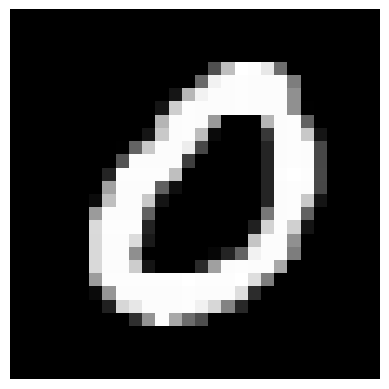

In [92]:
idx = 14
conditioning = torch.clone(mnist_batch[idx:(idx+1)]).to(device)
plt.imshow(conditioning[0, 0].cpu().numpy(), cmap="gray")
plt.axis('off')
plt.savefig(
    os.path.join(save_base_dir, 'full.png'),
    cmap="gray")

/tmp/ipykernel_24278/2992995488.py:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "cmap" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(


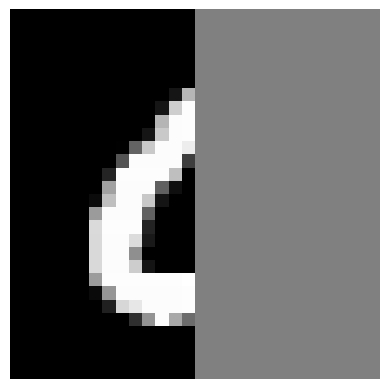

In [93]:
num_pixels = conditioning.shape[2]
conditioning_mask = torch.zeros_like(conditioning).to(device)
conditioning_mask[:, :,  :, :(num_pixels//2)] = 1
conditioning *= conditioning_mask
plt.imshow(conditioning[0, 0].cpu().numpy(), cmap="gray")
plt.axis('off')
plt.savefig(
    os.path.join(save_base_dir, 'condition.png'),
    cmap="gray")

In [94]:
# Calculate forward diffusion
motif_traj = ddpm.forward_trajectory(conditioning, device)
motif_traj = [conditioning_mask * x for x in motif_traj]

In [95]:
batch_size = 16
batched_motif_traj = [x.repeat(batch_size, 1, 1, 1) for x in motif_traj]
batched_conditioning_mask = conditioning_mask.repeat(batch_size, 1, 1, 1)

ddpm.eval()
with torch.no_grad():
    xh = ddpm.replacement_sample(batch_size, (1, 28, 28), device, batched_motif_traj, batched_conditioning_mask)
    grid = make_grid(xh, nrow=int(np.sqrt(batch_size)))
    save_image(
        grid,
        os.path.join(save_base_dir, 'replacement.png')
    )

In [96]:
particle_size = 16
batched_motif_traj = [x.repeat(particle_size, 1, 1, 1) for x in motif_traj]
batched_conditioning_mask = conditioning_mask.repeat(particle_size, 1, 1, 1)

batch_size = 16
smc_samples = []
ddpm.eval()
with torch.no_grad():
    for i in range(batch_size):
        path_name = os.path.join(save_base_dir, f'smc_k_{particle_size}_{i}.png')
        xh = ddpm.smc_sample(particle_size, (1, 28, 28), device, batched_motif_traj, batched_conditioning_mask)
        smc_samples.append(xh)
        grid = make_grid(xh, nrow=int(np.sqrt(particle_size)))
        save_image(grid, path_name)
        print(i)
new_smc_batch = torch.stack([x[0] for x in smc_samples])
grid = make_grid(new_smc_batch, nrow=int(np.sqrt(batch_size)))
save_image(grid, os.path.join(save_base_dir, f'grid_smc_k_{particle_size}.png'))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [97]:
particle_size = 64
batched_motif_traj = [x.repeat(particle_size, 1, 1, 1) for x in motif_traj]
batched_conditioning_mask = conditioning_mask.repeat(particle_size, 1, 1, 1)

batch_size = 16
smc_samples = []
ddpm.eval()
with torch.no_grad():
    for i in range(batch_size):
        path_name = os.path.join(save_base_dir, f'smc_k_{particle_size}_{i}.png')
        xh = ddpm.smc_sample(particle_size, (1, 28, 28), device, batched_motif_traj, batched_conditioning_mask)
        smc_samples.append(xh)
        grid = make_grid(xh, nrow=int(np.sqrt(particle_size)))
        save_image(grid, path_name)
        print(i)
new_smc_batch = torch.stack([x[0] for x in smc_samples])
grid = make_grid(new_smc_batch, nrow=int(np.sqrt(batch_size)))
save_image(grid, os.path.join(save_base_dir, f'grid_smc_k_{particle_size}.png'))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [34]:
grid = make_grid(smc_samples[3], nrow=4)
save_image(grid, f"/data/rsg/chemistry/jyim/projects/protein_diffusion/notebooks/contents/smc_2.png")

In [ ]:
sampled_diffusion = [x_T]
for t in reversed(range(num_t)):
    x_t = sampled_diffusion[-1]
    e_t = next_step_pred_with_motif(
        x_t, t, exp, motif_forward_diffusion,
        motif_idcs, inference_feats)

    x_t_1 = prot_diffuser.ar_reverse_diffusion(x_t, e_t, t).type(torch.float32)
    x_t_1 *= inference_feats['bb_mask'][..., None].cpu()

    sampled_diffusion.append(x_t_1)
    if t % log_freq == (log_freq-1):
        print(f'On {t}')

In [ ]:
import torch
import numpy as np
from inpainting import inpaint

def inpaint_particle_filter(
    N_particles, exp, target_len, motif_forward_diffusion,
    motif_idcs, prot_diffuser, log_freq = 100):
    T = exp.cfg.experiment.T

    # characteristics of particle filtering trajectory & resampling
    ws, N_replace, resample_times = [], [], []

    # set mask to have correct batch dimension
    inference_feats= {
            'bb_mask':torch.zeros([N_particles, target_len]),
            'residue_index':torch.tile(torch.arange(target_len),[N_particles,1])
            }
    inference_feats['bb_mask'][:, :target_len] = 1.

    # initialize weights to ones.
    weights = np.ones([N_particles])

    # Sample x_T as random noise
    x_T = torch.Tensor(np.random.normal(
        size=list(inference_feats['bb_mask'].shape) + [3])).type(torch.float32)

    sampled_diffusion = [x_T]
    for t in reversed(range(T)):
        if t % log_freq == (log_freq-1): print(f'On {t}')

        # predict error with diffusion model
        x_t = sampled_diffusion[-1]
        e_t = inpaint.next_step_pred_with_motif(
            x_t, t, exp, motif_forward_diffusion,
            motif_idcs, inference_feats)

        # compute importance weights
        log_w = log_impt_weights(
            prot_diffuser, x_t, e_t, t, motif_forward_diffusion,
            motif_idcs)

        # Update Self-normalized importance weights
        weights = weights*torch.exp(log_w).cpu().detach().numpy()
        weights /= sum(weights) # Re-normalize
        ws.append(weights)

        # Residual resample, but only if
        #   (1) weights are sufficiently non-uniform, and
        #   (2)(optionally) not too close to end of the trajectory
        departure_from_uniform = np.sum(abs(N_particles*weights-1))
        #if (departure_from_uniform > 0.75*N_particles) and t > T//20: ()
        if departure_from_uniform > 0.75*N_particles:
            print(t, "resampling, departure=%0.02f"%departure_from_uniform)
            idcs, N_replace_t = residual_resample(weights)
            resample_times.append(t)
            N_replace.append(N_replace_t)

            # Apply resampling
            x_t, e_t = x_t[idcs], e_t[idcs]

            # Reset weights to uniform
            weights = np.ones_like(weights)/N_particles

        x_t_1 = prot_diffuser.ar_reverse_diffusion(x_t, e_t, t).type(torch.float32)
        x_t_1 *= inference_feats['bb_mask'][..., None].cpu()
        sampled_diffusion.append(x_t_1)

    return sampled_diffusion, N_replace, ws, resample_times